Number of subplots (axes) = 6


C:\Users\louislin\AppData\Local\Temp\ipykernel_36228\2860158462.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


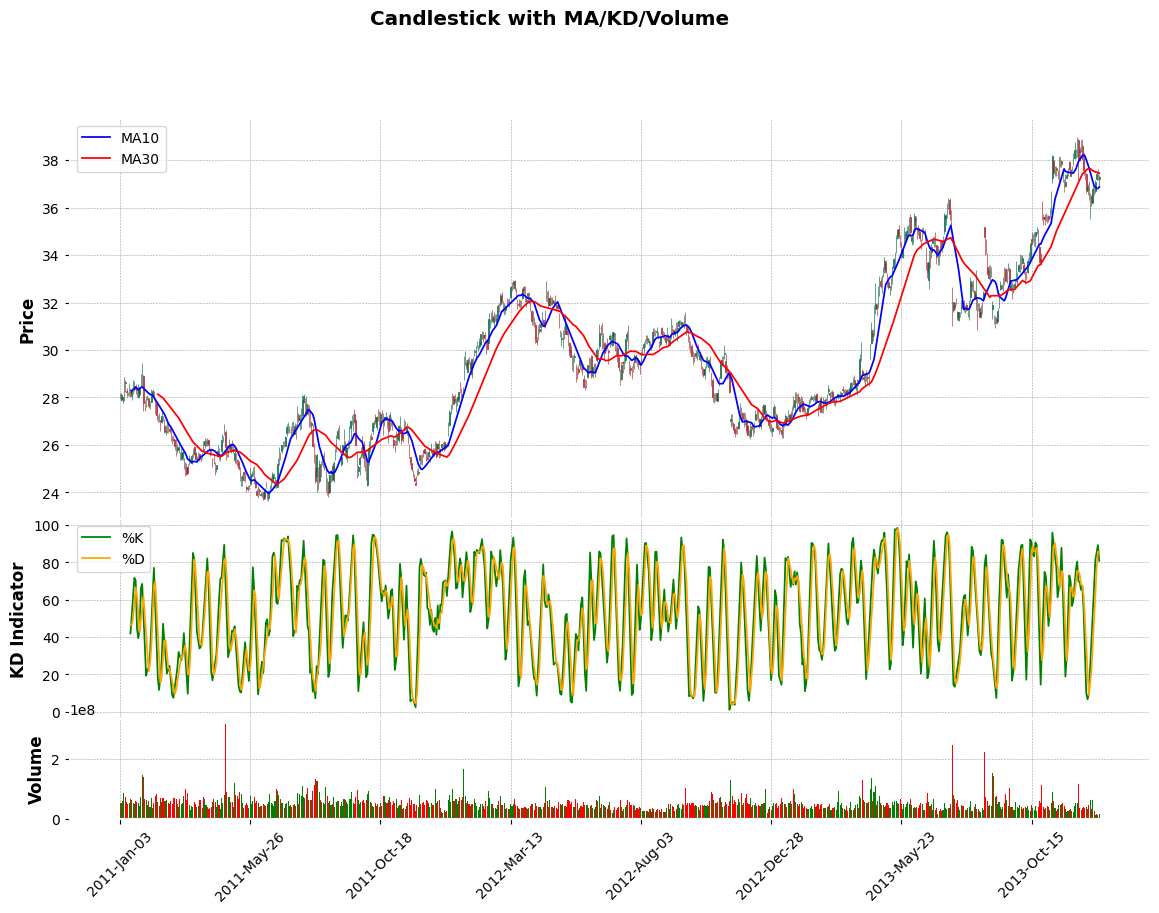

In [ ]:
import pandas as pd
import talib
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv("MSFT.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)

# 移除關鍵欄位的 NaN (至少要有 Open,High,Low,Close,Volume)
df.dropna(subset=['Open','High','Low','Close','Volume'], inplace=True)

# MA, KD
df['MA10'] = talib.SMA(df['Close'], 10)
df['MA30'] = talib.SMA(df['Close'], 30)
df['slowk'], df['slowd'] = talib.STOCH(df['High'], df['Low'], df['Close'])

# 設定 Volume 顏色
volume_colors = ['green' if c >= o else 'red' for c, o in zip(df['Close'], df['Open'])]

apds = [
    mpf.make_addplot(df['MA10'], color='blue', label='MA10'),
    mpf.make_addplot(df['MA30'], color='red',  label='MA30'),
    mpf.make_addplot(df['slowk'], panel=1, color='green',  label='%K'),
    mpf.make_addplot(df['slowd'], panel=1, color='orange', label='%D'),
    mpf.make_addplot(df['Volume'], panel=2, type='bar', color=volume_colors)
]

my_style = mpf.make_mpf_style(
    base_mpf_style='charles',
    y_on_right=False
)

# 加上 warn_too_much_data=999999 可以抑制「資料過多」的警告
fig, axes = mpf.plot(
    df,
    type='candle',
    style=my_style,
    addplot=apds,
    panel_ratios=(4, 2, 1),
    volume=False,
    figsize=(15, 10),
    title='Candlestick with MA/KD/Volume',
    returnfig=True,
    warn_too_much_data=999999
)

print(f"Number of subplots (axes) = {len(axes)}")
# 若你列印會看到 6 個 axes，原因如上所述

# 依照索引對「主軸」的 subplot 設 y-label
axes[0].set_ylabel('Price')
axes[2].set_ylabel('KD Indicator')
axes[4].set_ylabel('Volume')



# 顯示主圖圖例 (MA10/MA30)
axes[0].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import talib
df = pd.read_csv("MSFT.csv")
print(df.info())
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)

#seperate dataset
train_df = df.loc['2011-01-01':'2012-12-31'].copy()
val_df   = df.loc['2013-01-01':'2013-06-30'].copy()
test_df  = df.loc['2013-07-01':'2013-12-30'].copy()
print('='*30," Train ",'='*30)
print(train_df.head())
print(train_df.tail())
print('='*30," Validation ",'='*30)
print(val_df.head())
print(val_df.tail())
print('='*30," Test ",'='*30)
print(test_df.head())
print(test_df.tail())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       753 non-null    object 
 1   Open       753 non-null    float64
 2   High       753 non-null    float64
 3   Low        753 non-null    float64
 4   Close      753 non-null    float64
 5   Volume     753 non-null    int64  
 6   Adj Close  753 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 41.3+ KB
None
==============================  Train  ==============================
             Open   High    Low  Close    Volume  Adj Close
Date                                                       
2011-01-03  28.05  28.18  27.92  27.98  53443800      21.50
2011-01-04  27.94  28.17  27.85  28.09  54405600      21.59
2011-01-05  27.90  28.01  27.77  28.00  58998700      21.52
2011-01-06  28.04  28.85  27.86  28.82  88026300      22.15
2011-01-07  28.64  28.74  28.25  28.60

In [2]:
"""Adding New Feature"""
for data in [train_df, val_df, test_df]:
    data['MA10'] = talib.SMA(data['Close'], timeperiod=10)
    data['MA30'] = talib.SMA(data['Close'], timeperiod=30)
    data['K'], data['D'] = talib.STOCH(data['High'], data['Low'], data['Close'])
    data.fillna(0,inplace=True)
    print(data.head())
    print(data.info())

"""Normalization"""
feature_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA10', 'MA30', 'K', 'D']
scaler = MinMaxScaler()
scaler.fit(train_df[feature_cols])

train_scaled = scaler.transform(train_df[feature_cols])
val_scaled = scaler.transform(val_df[feature_cols])
test_scaled = scaler.transform(test_df[feature_cols])
    

             Open   High    Low  Close    Volume  Adj Close  MA10  MA30    K  \
Date                                                                           
2011-01-03  28.05  28.18  27.92  27.98  53443800      21.50   0.0   0.0  0.0   
2011-01-04  27.94  28.17  27.85  28.09  54405600      21.59   0.0   0.0  0.0   
2011-01-05  27.90  28.01  27.77  28.00  58998700      21.52   0.0   0.0  0.0   
2011-01-06  28.04  28.85  27.86  28.82  88026300      22.15   0.0   0.0  0.0   
2011-01-07  28.64  28.74  28.25  28.60  73762000      21.98   0.0   0.0  0.0   

              D  
Date             
2011-01-03  0.0  
2011-01-04  0.0  
2011-01-05  0.0  
2011-01-06  0.0  
2011-01-07  0.0  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2011-01-03 to 2012-12-31
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       502 non-null    float64
 1   High       502 non-null    float64
 2   Low        502 non-null 

In [3]:
def create_sequences(data, seq_len=30):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i:i+seq_len])          # 前30天
        y.append(data[i+seq_len][3])         # 第31天的 Close (第4欄)
    return np.array(x), np.array(y)
    
X_train, y_train = create_sequences(train_scaled)
X_val, y_val     = create_sequences(val_scaled)
X_test, y_test   = create_sequences(test_scaled)
print(len(X_train))
print(len(y_train))

472
472


In [4]:
"""Design Model"""
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, mode='RNN'):
        super(RNNModel, self).__init__()
        self.mode = mode
        if mode == 'RNN':
            self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        elif mode == 'LSTM':
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        elif mode == 'GRU':
            self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        else:
            raise ValueError("Invalid RNN mode")
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden)



--- Training RNN | Batch=32, LR=0.001, Layers=8, Epochs=10 ---
Epoch 1/10, Train Loss: 0.086131, Val Loss: 0.151372
Epoch 2/10, Train Loss: 0.043447, Val Loss: 0.106159
Epoch 3/10, Train Loss: 0.015062, Val Loss: 0.097202
Epoch 4/10, Train Loss: 0.009679, Val Loss: 0.056706
Epoch 5/10, Train Loss: 0.006453, Val Loss: 0.033754
Epoch 6/10, Train Loss: 0.006321, Val Loss: 0.024528
Epoch 7/10, Train Loss: 0.004362, Val Loss: 0.030836
Epoch 8/10, Train Loss: 0.004177, Val Loss: 0.021956
Epoch 9/10, Train Loss: 0.003863, Val Loss: 0.025751
Epoch 10/10, Train Loss: 0.003375, Val Loss: 0.019635


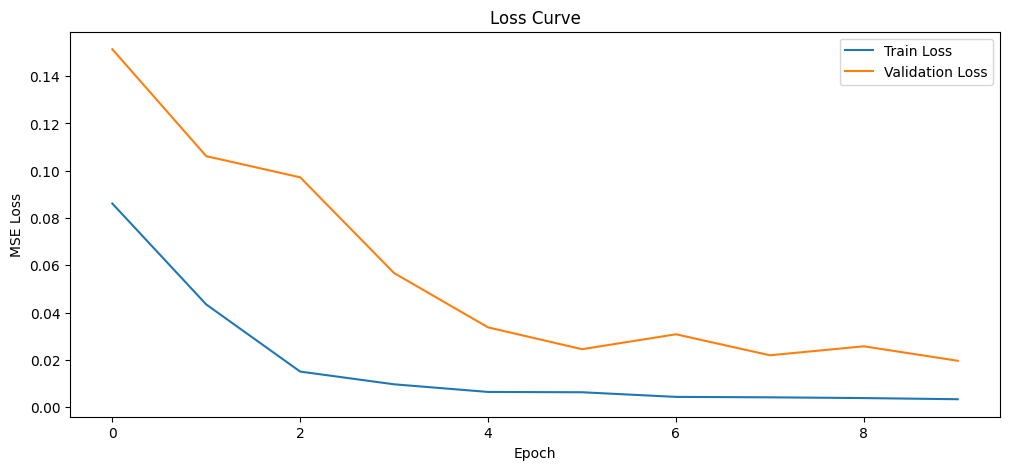


--- Training RNN | Batch=32, LR=0.001, Layers=8, Epochs=20 ---
Epoch 1/20, Train Loss: 0.093802, Val Loss: 0.168755
Epoch 2/20, Train Loss: 0.029503, Val Loss: 0.143586
Epoch 3/20, Train Loss: 0.014013, Val Loss: 0.060805
Epoch 4/20, Train Loss: 0.007502, Val Loss: 0.041568
Epoch 5/20, Train Loss: 0.005647, Val Loss: 0.024670
Epoch 6/20, Train Loss: 0.005413, Val Loss: 0.032956
Epoch 7/20, Train Loss: 0.004287, Val Loss: 0.021522
Epoch 8/20, Train Loss: 0.004657, Val Loss: 0.022719
Epoch 9/20, Train Loss: 0.003761, Val Loss: 0.022090
Epoch 10/20, Train Loss: 0.003008, Val Loss: 0.017171
Epoch 11/20, Train Loss: 0.002661, Val Loss: 0.017346
Epoch 12/20, Train Loss: 0.002955, Val Loss: 0.012856
Epoch 13/20, Train Loss: 0.002734, Val Loss: 0.014335
Epoch 14/20, Train Loss: 0.003455, Val Loss: 0.023158
Epoch 15/20, Train Loss: 0.002588, Val Loss: 0.017939
Epoch 16/20, Train Loss: 0.002261, Val Loss: 0.014647
Epoch 17/20, Train Loss: 0.002228, Val Loss: 0.015403
Epoch 18/20, Train Loss: 0.

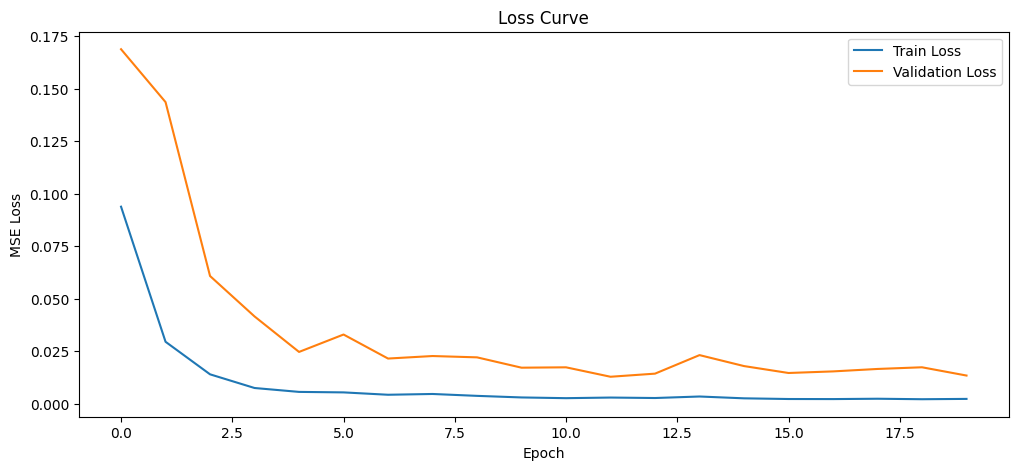


--- Training RNN | Batch=32, LR=0.01, Layers=8, Epochs=10 ---
Epoch 1/10, Train Loss: 0.182157, Val Loss: 0.225283
Epoch 2/10, Train Loss: 0.088818, Val Loss: 0.176230
Epoch 3/10, Train Loss: 0.086656, Val Loss: 0.152698
Epoch 4/10, Train Loss: 0.078998, Val Loss: 0.224615
Epoch 5/10, Train Loss: 0.072564, Val Loss: 0.335544
Epoch 6/10, Train Loss: 0.073951, Val Loss: 0.223943
Epoch 7/10, Train Loss: 0.076464, Val Loss: 0.193447
Epoch 8/10, Train Loss: 0.073609, Val Loss: 0.291729
Epoch 9/10, Train Loss: 0.077814, Val Loss: 0.290180
Epoch 10/10, Train Loss: 0.085145, Val Loss: 0.349958

--- Training RNN | Batch=32, LR=0.01, Layers=8, Epochs=20 ---
Epoch 1/20, Train Loss: 0.333272, Val Loss: 0.108566
Epoch 2/20, Train Loss: 0.101583, Val Loss: 0.375250
Epoch 3/20, Train Loss: 0.074514, Val Loss: 0.242921
Epoch 4/20, Train Loss: 0.072295, Val Loss: 0.213375
Epoch 5/20, Train Loss: 0.074722, Val Loss: 0.341842
Epoch 6/20, Train Loss: 0.080319, Val Loss: 0.301125
Epoch 7/20, Train Loss: 0

In [8]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch

def plot_losses_curve(train_losses,val_losses):
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

"""Model Training"""
def to_tensor(x, y):
    return TensorDataset(torch.tensor(x, dtype=torch.float32),
                         torch.tensor(y, dtype=torch.float32))

MODEL = "RNN"
params_dict = {
    "batch_size": [32,],
    "lr": [0.001, 0.01],
    "num_layers": [8],
    "epoch": [10, 20]
}

# Track global best model
global_best_val_loss = float('inf')
global_best_model_state = None
global_best_config = None

for batch_size in params_dict['batch_size']:
    for lr in params_dict['lr']:
        for num_layers in params_dict['num_layers']:
            for n_epochs in params_dict['epoch']:

                print(f"\n--- Training {MODEL} | Batch={batch_size}, LR={lr}, Layers={num_layers}, Epochs={n_epochs} ---")

                """Prepare datasets"""
                train_loader = DataLoader(to_tensor(X_train, y_train), batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(to_tensor(X_val, y_val), batch_size=batch_size)
                test_loader = DataLoader(to_tensor(X_test, y_test), batch_size=batch_size)

                """Prepare Training"""
                input_dim = X_train.shape[2]
                hidden_dim = 64
                model = RNNModel(input_dim, hidden_dim, num_layers, MODEL)
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                """Evolution Parameters"""
                train_losses = []
                val_losses = []

                """Early Stopping"""
                early_stopping_patience = 10
                best_val_loss = float('inf')
                patience_counter = 0

                """Start Training"""
                for epoch in range(n_epochs):
                    model.train()
                    train_loss = 0.0
                    for xb, yb in train_loader:
                        pred = model(xb).squeeze()
                        loss = criterion(pred, yb)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        train_loss += loss.item()

                    avg_train_loss = train_loss / len(train_loader)
                    train_losses.append(avg_train_loss)

                    # validation loss
                    model.eval()
                    val_loss = 0.0
                    with torch.no_grad():
                        for xb, yb in val_loader:
                            pred = model(xb).squeeze()
                            loss = criterion(pred, yb)
                            val_loss += loss.item()
                    avg_val_loss = val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)

                    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

                    # Early stopping check
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= early_stopping_patience:
                            print("Early stopping triggered.")
                            break

                # Global best model check
                if best_val_loss < global_best_val_loss:
                    global_best_val_loss = best_val_loss
                    global_best_model_state = model.state_dict()
                    plot_losses_curve(train_losses,val_losses)
                    global_best_config = {
                        'batch_size': batch_size,
                        'lr': lr,
                        'num_layers': num_layers,
                        'epochs': n_epochs
                    }

# Save only the best model from all combinations
if global_best_model_state is not None:
    torch.save(global_best_model_state, f"best_{MODEL}_overall.pth")
    print(f"\nSaved best overall model as best_{MODEL}_overall.pth")
    print("Best config:", global_best_config)
    print("Best validation loss:", global_best_val_loss)


Test MAE: 2.0386, RMSE: 6.3321


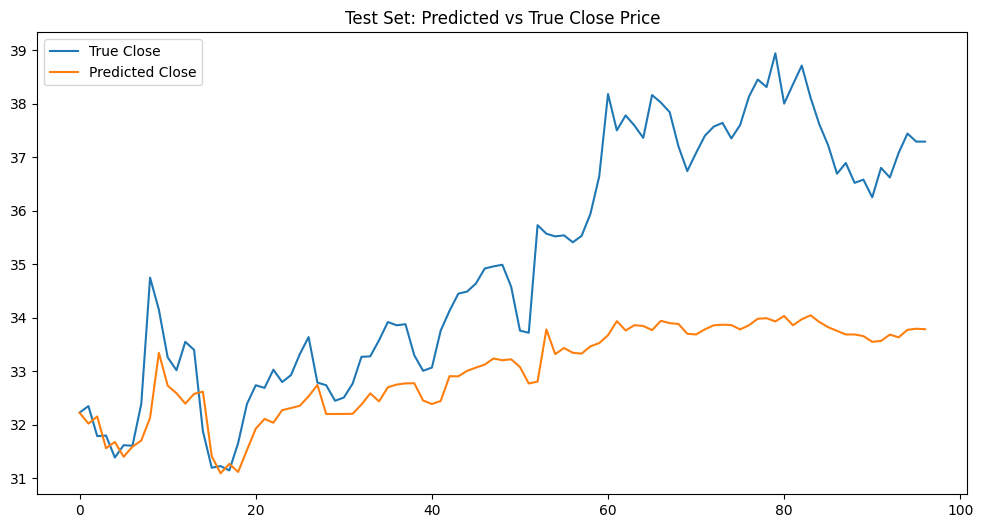

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Reload best model for evaluation
input_dim = X_train.shape[2]
hidden_dim = 64
best_model = RNNModel(input_dim, hidden_dim, global_best_config['num_layers'], MODEL)
best_model.load_state_dict(torch.load(f"best_{MODEL}_overall.pth"))
best_model.eval()

# Evaluate on test set
# Evaluate on test set
predictions = []
actuals = []
with torch.no_grad():
    for xb, yb in DataLoader(to_tensor(X_test, y_test), batch_size=global_best_config['batch_size']):
        pred = best_model(xb)
        if pred.ndim == 1:
            predictions.extend(pred.tolist())
        else:
            predictions.extend(pred.squeeze(-1).tolist())
        actuals.extend(yb.tolist())

# Inverse transform
close_index = feature_cols.index('Close')
min_close = scaler.data_min_[close_index]
max_close = scaler.data_max_[close_index]
inverse = lambda z: z * (max_close - min_close) + min_close
predicted_close = [inverse(p) for p in predictions]
true_close = [inverse(a) for a in actuals]

# Evaluation metrics
mae = mean_absolute_error(true_close, predicted_close)
rmse = mean_squared_error(true_close, predicted_close)
print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Plot prediction result
plt.figure(figsize=(12, 6))
plt.plot(true_close, label='True Close')
plt.plot(predicted_close, label='Predicted Close')
plt.legend()
plt.title('Test Set: Predicted vs True Close Price')
plt.show()

